# 6. Advanced plotting

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import seaborn as sns

We have seen already two options to plot data: we can use the "raw" Matplotlib which in principle allows one to create any possible plot, however with lots of code, and we saw the simpler internal Pandas solution. While the latter solution is very practical to quickly look through data, it is rather cumbersome to realise more complex plots.

Here we look at another type of plotting resting on the concepts of the grammar of graphics. This approach allows to create complex plots where data can be simply split in a plot into color, shapes etc. without having to do a grouping operation in beforehand. We will mainly look at Seaborn, and finish with an example with Plotnine, the port to Python of ggplot.

## Importing data

We come back here to the dataset of swiss towns. To make the dataset more interestig we add to it some categorical data. First we attempt to add the main language for each town. It is a good example of the type of data wranglig one ofen has to do by combining information from different sources.

In [3]:
#load table indicating to which canton each town belongs
cantons = pd.read_excel('../Datasets/be-b-00.04-osv-01.xls',sheet_name=1)[['KTKZ','ORTNAME']]

In [4]:
#load general table with infos on towns
towns = pd.read_excel('../Datasets/2018.xls', skiprows=list(range(5))+list(range(6,9)),
                      skipfooter=34, index_col='Commune',na_values=['*','X'])
towns = towns.reset_index()

In [5]:
#merge tables using the town name. This adds the canton abbreviation to the main table 
towns_canton = pd.merge(towns, cantons, left_on='Commune', right_on='ORTNAME',how = 'inner')

In [6]:
#load data indicating languages of each canton
language = pd.read_excel('../Datasets/je-f-01.08.01.02.xlsx',skiprows=[0,2,3,4],skipfooter=11)
languages = language[['Allemand (ou suisse allemand)','Français (ou patois romand)',
         'Italien (ou dialecte tessinois/italien des grisons)']]
languages = languages.apply(pd.to_numeric, errors='coerce')
#check which language has majority in each canton
languages['language'] = np.argmax(languages.values.astype(float),axis=1)
code={0:'German', 1:'French', 2:'Italian'}
languages['Language'] = languages.language.apply(lambda x: code[x])
languages['canton'] = language['Unnamed: 0']
languages = languages[['canton','Language']]

#load table matching canton name to abbreviation
cantons_abbrev = pd.read_excel('../Datasets/cantons_abbrev.xlsx')
#add full canton name to table by merging on abbreviation
canton_language = pd.merge(languages, cantons_abbrev,on='canton')

In [7]:
#add language by merging on canton abbreviation
towns_language = pd.merge(towns_canton, canton_language, left_on='KTKZ', right_on='abbrev')

In [8]:
towns_language['town_type'] = towns_language['Surface agricole en %'].apply(lambda x: 'Land' if x<50 else 'City')

In [9]:
#Create a new party column and a new party score column
parties = pd.melt(towns_language,id_vars=['Commune'], value_vars=['UDC','PS','PDC'], 
                  var_name= 'Party', value_name='Party score')
towns_language = pd.merge(parties, towns_language, on='Commune')

towns_language

,Commune,Party,Party score,Code commune,Habitants,Variation en %,Densité de la population par km²,Etrangers en %,0-19 ans,20-64 ans,...,PBD,PST/Sol.,PES,Petits partis de droite,KTKZ,ORTNAME,canton,Language,abbrev,town_type
0,Aeugst am Albis,UDC,30.929249,1,1977,8.388158,249.936789,13.100658,20.586748,62.822458,...,2.617442,0.167638,7.075094,4.888178,ZH,Aeugst am Albis,Zurich,German,ZH,City
1,Aeugst am Albis,PS,18.645940,1,1977,8.388158,249.936789,13.100658,20.586748,62.822458,...,2.617442,0.167638,7.075094,4.888178,ZH,Aeugst am Albis,Zurich,German,ZH,City
2,Aeugst am Albis,PDC,2.076428,1,1977,8.388158,249.936789,13.100658,20.586748,62.822458,...,2.617442,0.167638,7.075094,4.888178,ZH,Aeugst am Albis,Zurich,German,ZH,City
3,Affoltern am Albis,UDC,33.785785,2,11900,7.294203,1123.701605,27.848740,20.285714,62.201681,...,4.164299,0.190049,6.211047,1.768197,ZH,Affoltern am Albis,Zurich,German,ZH,Land
4,Affoltern am Albis,PS,19.080314,2,11900,7.294203,1123.701605,27.848740,20.285714,62.201681,...,4.164299,0.190049,6.211047,1.768197,ZH,Affoltern am Albis,Zurich,German,ZH,Land
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6343,Bure,PS,8.859060,6778,685,3.162651,50.036523,6.131387,19.854015,54.306569,...,NaN,0.671141,1.208054,NaN,JU,Bure,Jura,French,JU,Land
6344,Bure,PDC,49.395973,6778,685,3.162651,50.036523,6.131387,19.854015,54.306569,...,NaN,0.671141,1.208054,NaN,JU,Bure,Jura,French,JU,Land
6345,Coeuve,UDC,8.194444,6781,732,8.124077,62.994836,3.551913,25.136612,56.147541,...,NaN,2.222222,5.000000,NaN,JU,Coeuve,Jura,French,JU,City
6346,Coeuve,PS,24.722222,6781,732,8.124077,62.994836,3.551913,25.136612,56.147541,...,NaN,2.222222,5.000000,NaN,JU,Coeuve,Jura,French,JU,City


## Basic plotting

We finally have a table with mostly numerical information but also two categorical data: language and town type (land or city). With Seaborn we can now easily make all sorts of plots. For example what are the average scores of the different parties:

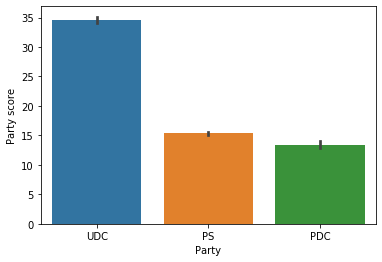

In [10]:
sns.barplot(data = towns_language, y='Party score', x = 'Party');

Do land towns vote more for the right-wing party ?

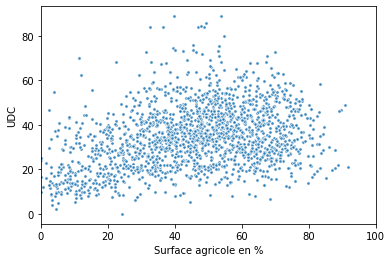

In [11]:
g = sns.scatterplot(data = towns_language, y='UDC', x = 'Surface agricole en %', s = 10, alpha = 0.5);
g.set_xlim([0,100]);

## Using categories as "aesthetics"

The greate advantage of using these packages is that they allow to include categories as "aesthetics" of the plot. For example we looked before at average party scores. But are they different between language regions ? We can just specify that the hue (color) should be mapped to the town language:

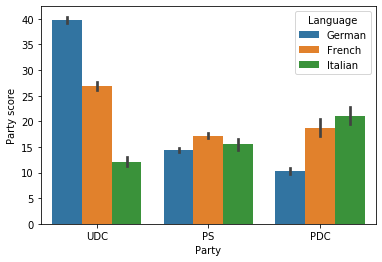

In [12]:
sns.barplot(data = towns_language, y='Party score', x = 'Party', hue = 'Language');

Similarly with scatter plots. Is the relation between land and voting on the right language dependent ?

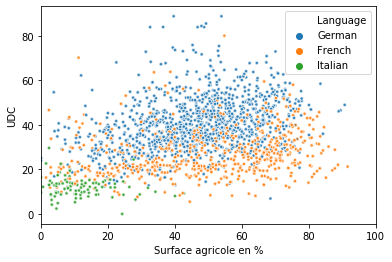

In [13]:
g = sns.scatterplot(data = towns_language, y='UDC', x = 'Surface agricole en %', hue = 'Language',
                    s = 10, alpha = 0.5);
g.set_xlim([0,100]);

## Statistics

We see difference in the last plot, but it is still to clearly see the relation. Luckiliy these packages allow us to either create summary statistics or to fit the data:

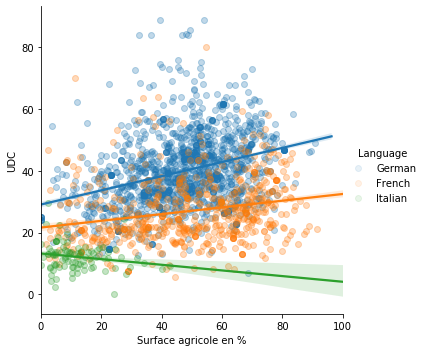

In [14]:
g = sns.lmplot(data = towns_language, x = 'Surface agricole en %', y='UDC', hue = 'Language', scatter=True,
              scatter_kws={'alpha': 0.1});
g.ax.set_xlim([0,100]);

Now we can also do the same exercise for all parties. Does the relation hold?

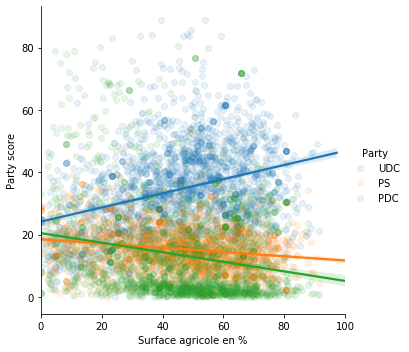

In [15]:
g = sns.lmplot(data = towns_language, x = 'Surface agricole en %', y='Party score', 
               hue = 'Party', scatter=True,
              scatter_kws={'alpha': 0.1});
g.ax.set_xlim([0,100]);

## Adding eve more information

We can recover from some other place (Poste) the coordinates of each town. Again by merging we can add that information to our main table: 

In [16]:
coords = pd.read_csv('../Datasets/plz_verzeichnis_v2.csv', sep=';')[['ORTBEZ18','Geokoordinaten']]
coords['lat'] = coords.Geokoordinaten.apply(lambda x: float(x.split(', ')[0]) if type(x)==str else np.nan)
coords['long'] = coords.Geokoordinaten.apply(lambda x: float(x.split(', ')[1]) if type(x)==str else np.nan)


In [17]:
towns_language = pd.merge(towns_language,coords, left_on='Commune', right_on='ORTBEZ18')

So now we can in addition look at the geography of these parameters. For example, who votes for the right-wing party ?

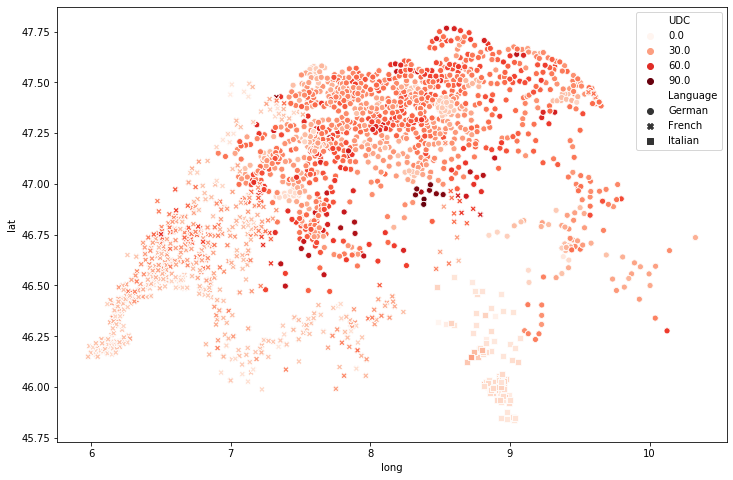

In [18]:
fix, ax = plt.subplots(figsize = (12,8))
sns.scatterplot(data = towns_language, x= 'long', y = 'lat', hue='UDC', style = 'Language', palette='Reds');
